# Understanding Insurance policy quote conversions 
Which customers will purchase a quoted insurance plan?

##### Data Source - kaggle (https://www.kaggle.com/c/homesite-quote-conversion/data) 
Information about customers.We are Suppose to predict whether customer will buy suggested quote or not

In [1]:
#import all the required libraries 
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score

In [2]:
#Load the csv file using pandas which we downloaded from kaggle 
homesite_train =  pd.read_csv('train_homesite.csv')
homesite_test = pd.read_csv('test_homesite.csv')

print(homesite_train.shape)
print(homesite_test.shape)

(260753, 299)
(173836, 298)


In [3]:
#Date field manipulations - tarining dataset 
homesite_train['Original_Quote_Date'] = pd.to_datetime(pd.Series(homesite_train['Original_Quote_Date']))
homesite_train['Year'] = homesite_train['Original_Quote_Date'].apply(lambda x: int(str(x)[:4]))
homesite_train['Month'] = homesite_train['Original_Quote_Date'].apply(lambda x: int(str(x)[5:7]))
homesite_train['weekday'] = homesite_train['Original_Quote_Date'].dt.dayofweek

#Date field manipulations - testing dataset
homesite_test['Original_Quote_Date'] = pd.to_datetime(pd.Series(homesite_test['Original_Quote_Date']))
homesite_test['Year'] = homesite_test['Original_Quote_Date'].apply(lambda x: int(str(x)[:4]))
homesite_test['Month'] = homesite_test['Original_Quote_Date'].apply(lambda x: int(str(x)[5:7]))
homesite_test['weekday'] = homesite_test['Original_Quote_Date'].dt.dayofweek

In [4]:
#Check the shape of training & testing data 
print('Training dataset shape :', homesite_train.shape)
print('Testing dataset shape :', homesite_test.shape)

Training dataset shape : (260753, 302)
Testing dataset shape : (173836, 301)


In [5]:
#missing values in training dataset 
num_homesite_train = homesite_train.isnull().sum().sort_values(ascending=False)
#missing values in percentage 
num_homesite_train= homesite_train.isnull().sum().sort_values(ascending=False)/len(homesite_train)*100
# Printing only those colulmns which have null values 
num_homesite_train = num_homesite_train[num_homesite_train!= 0]
num_homesite_train

PropertyField29    76.963640
PersonalField84    47.634351
PropertyField38     0.467876
PropertyField36     0.043336
PersonalField7      0.043336
PropertyField3      0.031064
PropertyField34     0.026845
PropertyField32     0.026845
PropertyField4      0.024161
dtype: float64

In [6]:
#missing values in testing dataset 
null_homesite_test = homesite_test.isnull().sum().sort_values(ascending=False)
#missing values in percentage 
null_homesite_test = homesite_test.isnull().sum().sort_values(ascending=False)/len(homesite_test)*100
# Printing only those colulmns which have null values 
null_homesite_test = null_homesite_test[null_homesite_test!= 0]
null_homesite_test

PropertyField29    77.052509
PersonalField84    47.638004
PropertyField38     0.486666
PropertyField3      0.039693
PersonalField7      0.039693
PropertyField36     0.038542
PropertyField4      0.029913
PropertyField34     0.023585
PropertyField32     0.023585
PropertyField5      0.000575
PropertyField30     0.000575
dtype: float64

In [7]:
#remove columns which we are not going to use - all columns with null values in training dataset
homesite_train = homesite_train.drop(columns=['PropertyField29'])#homesite_train = homesite_train.drop(columns=['PersonalField84'])
homesite_train = homesite_train.drop(columns=['Original_Quote_Date'])
homesite_train = homesite_train.drop(columns=['PropertyField6'])
homesite_train = homesite_train.drop(columns=['GeographicField10A'])
print(homesite_train.shape)

(260753, 298)


In [8]:
#remove columns which we are not going to use - all columns with null values in testing dataset
homesite_test = homesite_test.drop(columns=['PropertyField29'])#homesite_test = homesite_test.drop(columns=['PersonalField84'])
homesite_test = homesite_test.drop(columns=['Original_Quote_Date'])
homesite_test = homesite_test.drop(columns=['PropertyField6'])
homesite_test = homesite_test.drop(columns=['GeographicField10A'])
print(homesite_test.shape)

(173836, 297)


In [9]:
#remove duplicate rows 
homesite_train = homesite_train.drop_duplicates()
print(homesite_train.shape)

homesite_test = homesite_test.drop_duplicates()
print(homesite_test.shape)

(260753, 298)
(173836, 297)


In [10]:
#fillna (-99)
homesite_train=homesite_train.fillna(-99)
homesite_test=homesite_test.fillna(-99)

In [11]:
## Converting categorical variables into numeric variables with label encoder
from sklearn.preprocessing import LabelEncoder  

for cat in homesite_train.columns:
    if homesite_train[cat].dtype=='object':
        print(cat)
        lbl=preprocessing.LabelEncoder()
        lbl.fit(list(homesite_train[cat].values))
        homesite_train[cat]=lbl.transform(list(homesite_train[cat].values))
        print(cat)

Field6
Field6
Field10
Field10
Field12
Field12
CoverageField8
CoverageField8
CoverageField9
CoverageField9
SalesField7
SalesField7
PersonalField7
PersonalField7
PersonalField16
PersonalField16
PersonalField17
PersonalField17
PersonalField18
PersonalField18
PersonalField19
PersonalField19
PropertyField3
PropertyField3
PropertyField4
PropertyField4
PropertyField5
PropertyField5
PropertyField7
PropertyField7
PropertyField14
PropertyField14
PropertyField28
PropertyField28
PropertyField30
PropertyField30
PropertyField31
PropertyField31
PropertyField32
PropertyField32
PropertyField33
PropertyField33
PropertyField34
PropertyField34
PropertyField36
PropertyField36
PropertyField37
PropertyField37
PropertyField38
PropertyField38
GeographicField63
GeographicField63
GeographicField64
GeographicField64


In [12]:
## Converting categorical variables into numeric variables with label encoder
for cat in homesite_test.columns:
    if homesite_test[cat].dtype=='object':
        print(cat)
        lbl=preprocessing.LabelEncoder()
        lbl.fit(list(homesite_test[cat].values))
        homesite_test[cat]=lbl.transform(list(homesite_test[cat].values))
        print(cat)

Field6
Field6
Field10
Field10
Field12
Field12
CoverageField8
CoverageField8
CoverageField9
CoverageField9
SalesField7
SalesField7
PersonalField7
PersonalField7
PersonalField16
PersonalField16
PersonalField17
PersonalField17
PersonalField18
PersonalField18
PersonalField19
PersonalField19
PropertyField3
PropertyField3
PropertyField4
PropertyField4
PropertyField5
PropertyField5
PropertyField7
PropertyField7
PropertyField14
PropertyField14
PropertyField28
PropertyField28
PropertyField30
PropertyField30
PropertyField31
PropertyField31
PropertyField32
PropertyField32
PropertyField33
PropertyField33
PropertyField34
PropertyField34
PropertyField36
PropertyField36
PropertyField37
PropertyField37
PropertyField38
PropertyField38
GeographicField63
GeographicField63
GeographicField64
GeographicField64


In [13]:
#Top 77 features which are drawn from SelectKBest & ExtraTreeClassifier
X_train = homesite_train[['PropertyField37','PersonalField9','PersonalField10A','PersonalField12','PersonalField1','PersonalField2','PersonalField10B','PropertyField34','GeographicField11A','SalesField4','SalesField1B','Field10','CoverageField9','Field9','GeographicField12A','CoverageField11B','GeographicField7A','PropertyField32','PropertyField35','Field7','CoverageField8','SalesField3','SalesField1A','PersonalField13','PropertyField8','PersonalField4B','CoverageField6B','SalesField2B','SalesField6','PersonalField4A','CoverageField6A','PropertyField25','CoverageField11A','PropertyField18','SalesField2A','PropertyField33','CoverageField4B','PersonalField15','SalesField7','PropertyField2B','SalesField8','PropertyField26B','Month','PropertyField39A','SalesField10','PersonalField32','CoverageField1B','SalesField12','weekday','SalesField5','GeographicField9A','GeographicField6A','GeographicField13A','GeographicField8A','GeographicField20A','GeographicField16A','GeographicField15A','GeographicField14B','GeographicField7B','GeographicField12B','GeographicField8B','GeographicField16B','GeographicField9B','GeographicField15B','GeographicField20B','PersonalField82','GeographicField6B','GeographicField13B','Field8','GeographicField17B','PersonalField26','GeographicField11B','GeographicField44A','GeographicField44B','PersonalField81','GeographicField23B','GeographicField38B']]

y_train = homesite_train.QuoteConversion_Flag
print(X_train.shape)

(260753, 77)


In [14]:
#Split the training data into training & validation
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.3,random_state=0)

In [15]:
X_test = homesite_test[['PropertyField37','PersonalField9','PersonalField10A','PersonalField12','PersonalField1','PersonalField2','PersonalField10B','PropertyField34','GeographicField11A','SalesField4','SalesField1B','Field10','CoverageField9','Field9','GeographicField12A','CoverageField11B','GeographicField7A','PropertyField32','PropertyField35','Field7','CoverageField8','SalesField3','SalesField1A','PersonalField13','PropertyField8','PersonalField4B','CoverageField6B','SalesField2B','SalesField6','PersonalField4A','CoverageField6A','PropertyField25','CoverageField11A','PropertyField18','SalesField2A','PropertyField33','CoverageField4B','PersonalField15','SalesField7','PropertyField2B','SalesField8','PropertyField26B','Month','PropertyField39A','SalesField10','PersonalField32','CoverageField1B','SalesField12','weekday','SalesField5','GeographicField9A','GeographicField6A','GeographicField13A','GeographicField8A','GeographicField20A','GeographicField16A','GeographicField15A','GeographicField14B','GeographicField7B','GeographicField12B','GeographicField8B','GeographicField16B','GeographicField9B','GeographicField15B','GeographicField20B','PersonalField82','GeographicField6B','GeographicField13B','Field8','GeographicField17B','PersonalField26','GeographicField11B','GeographicField44A','GeographicField44B','PersonalField81','GeographicField23B','GeographicField38B']]
print(X_test.shape)

(173836, 77)


In [16]:
xgb = XGBClassifier(learning_rate=0.1,max_depth=3)
xgb.fit(X_train, y_train)

F:\Pritee\Installations\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
#predcting probability using xgboost for testing dataset
y_test = xgb.predict_proba(X_test)

In [18]:
#final submission 
df_submission=pd.read_csv('sample_submission.csv')
df_submission['QuoteConversion_Flag']=y_test[:,1]
df_submission.to_csv('xgboost_features.csv',index=False)

#df = y_test
#dict = {'QuoteNumber' : homesite_test['QuoteNumber'],'QuoteConversion_Flag':y_test}
#df = pd.DataFrame(dict)
#df.to_csv('submission_ensemble_final.csv', index=False)

In [19]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score

In [20]:
#Derive "y_pred" values based on X_val
y_pred = xgb.predict(X_val)

In [21]:
#Accuracy of validation data
print('Accuracy of LR :', accuracy_score(y_val, y_pred, normalize=True))

Accuracy of LR : 0.9216628742361874


In [22]:
#F1 score of validation data
print ('F1 Score :' , f1_score(y_val, y_pred, average='weighted'))

F1 Score : 0.9149643168421714


In [23]:
#log loss of validation data
print('Log loss :' ,log_loss(y_val, y_pred))

Log loss : 2.7056736423224037


In [24]:
#ROC/AUC of validation data
print ('ROC/AUC score :' ,roc_auc_score(y_val, y_pred, average='weighted'))

ROC/AUC score : 0.8054765354264879


roc_auc_score for DecisionTree:  0.9582721069267367


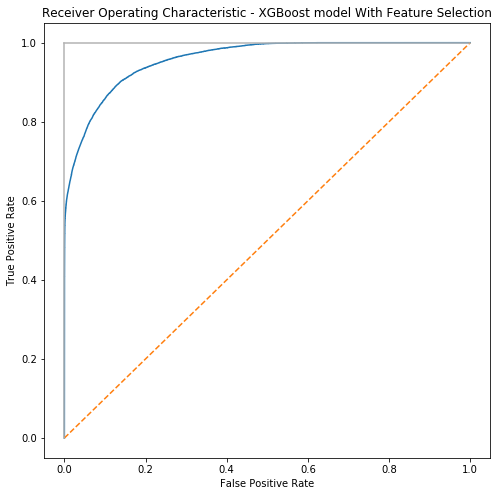

In [26]:
import matplotlib.pyplot as plt 
import sklearn.metrics as metrics
y_score1 = xgb.predict_proba(X_val)[:,1]
#y_score2 = clf_reg.predict_proba(X_test)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = metrics.roc_curve(y_val, y_score1)
#false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)

print('roc_auc_score for DecisionTree: ', roc_auc_score(y_val, y_score1))
#print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score2))
    
plt.subplots(1, figsize=(8,8))
plt.title('Receiver Operating Characteristic - XGBoost model With Feature Selection')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()